<a href="https://colab.research.google.com/github/saju0820/CodeSpace/blob/main/DenseNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import (
    confusion_matrix, accuracy_score, precision_score, recall_score,
    f1_score, mean_squared_error, cohen_kappa_score
)


In [ ]:
TRAIN_DIR = "/content/drive/MyDrive/diseases/train"
TEST_DIR  = "/content/drive/MyDrive/diseases/test"

In [ ]:
from torchvision import datasets
from collections import Counter
import pandas as pd

TRAIN_DIR = "/content/drive/MyDrive/diseases/train"

train_dataset = datasets.ImageFolder(TRAIN_DIR)

train_counts = Counter(train_dataset.targets)
train_classes = train_dataset.classes

df_train_balance = pd.DataFrame({
    "Class": train_classes,
    "Train Images": [train_counts[i] for i in range(len(train_classes))]
})

print("Total TRAIN images:", len(train_dataset))
df_train_balance


Total TRAIN images: 13280


,Class,Train Images
0,bacterial_leaf_blight,1332
1,brown_spot,1349
2,healthy,1385
3,leaf_blast,1368
4,leaf_scald,1385
5,narrow_brown_spot,1371
6,neck_blast,954
7,rice_hispa,1395
8,sheath_blight,1385
9,tungro,1356


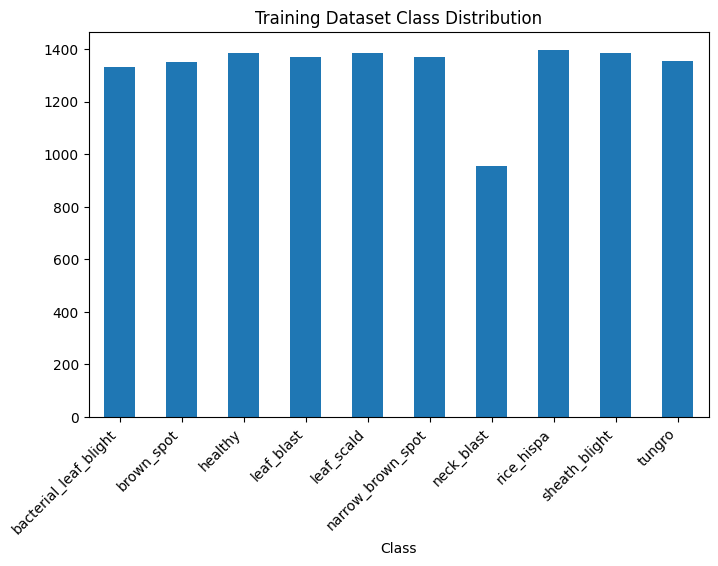

In [ ]:
import matplotlib.pyplot as plt

df_train_balance.plot(
    kind="bar",
    x="Class",
    y="Train Images",
    legend=False,
    figsize=(8,5)
)
plt.title("Training Dataset Class Distribution")
plt.xticks(rotation=45, ha="right")
plt.show()


In [ ]:
TEST_DIR = "/content/drive/MyDrive/diseases/test"

test_dataset = datasets.ImageFolder(TEST_DIR)

test_counts = Counter(test_dataset.targets)
test_classes = test_dataset.classes

df_test_balance = pd.DataFrame({
    "Class": test_classes,
    "Test Images": [test_counts[i] for i in range(len(test_classes))]
})

print("Total TEST images:", len(test_dataset))
df_test_balance


Total TEST images: 1929


,Class,Test Images
0,bacterial_leaf_blight,222
1,brown_spot,195
2,healthy,207
3,leaf_blast,165
4,leaf_scald,180
5,narrow_brown_spot,259
6,neck_blast,180
7,rice_hispa,168
8,sheath_blight,195
9,tungro,158


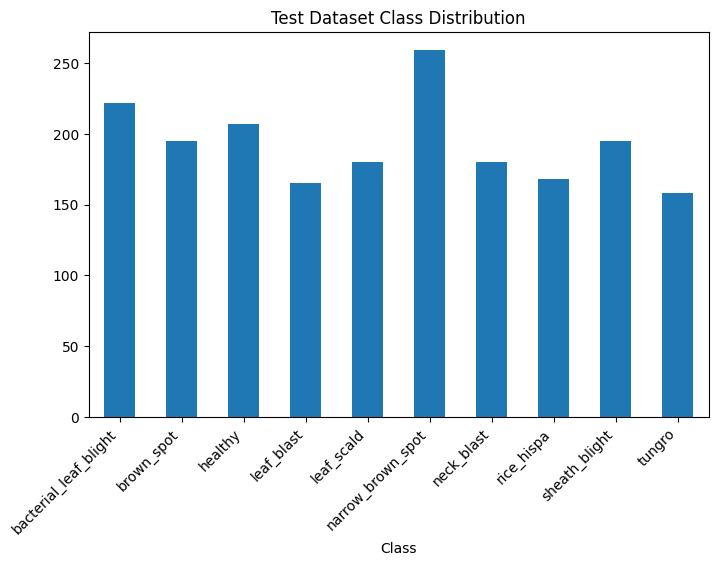

In [ ]:
df_test_balance.plot(
    kind="bar",
    x="Class",
    y="Test Images",
    legend=False,
    figsize=(8,5)
)
plt.title("Test Dataset Class Distribution")
plt.xticks(rotation=45, ha="right")
plt.show()


In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2  # 20% validation
)

test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
train_gen = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(224,224),
    batch_size=32,
    class_mode="categorical",
    subset="training",
    shuffle=True
)

val_gen = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(224,224),
    batch_size=32,
    class_mode="categorical",
    subset="validation",
    shuffle=False
)

Found 10627 images belonging to 10 classes.
Found 2653 images belonging to 10 classes.


In [ ]:
test_gen = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(224,224),
    batch_size=32,
    class_mode="categorical",
    shuffle=False
)

class_names = list(train_gen.class_indices.keys())
print("Classes:", class_names)

Found 1929 images belonging to 10 classes.
Classes: ['bacterial_leaf_blight', 'brown_spot', 'healthy', 'leaf_blast', 'leaf_scald', 'narrow_brown_spot', 'neck_blast', 'rice_hispa', 'sheath_blight', 'tungro']


In [ ]:
base_model = DenseNet121(weights="imagenet", include_top=False, input_shape=(224,224,3))

for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation="relu")(x)
output = Dense(len(class_names), activation="softmax")(x)

model = Model(inputs=base_model.input, outputs=output)

model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 56, 56,    │     12,288 │ conv2_block2_0_r

 Total params: 7,169,994 (27.35 MB)

 Trainable params: 132,490 (517.54 KB)

 Non-trainable params: 7,037,504 (26.85 MB)

In [ ]:
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=20,
    verbose=1
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
333/333 ━━━━━━━━━━━━━━━━━━━━ 6045s 18s/step - accuracy: 0.6152 - loss: 1.1422 - val_accuracy: 0.8243 - val_loss: 0.5192
Epoch 2/20
333/333 ━━━━━━━━━━━━━━━━━━━━ 370s 1s/step - accuracy: 0.8379 - loss: 0.4669 - val_accuracy: 0.8715 - val_loss: 0.3863
Epoch 3/20
333/333 ━━━━━━━━━━━━━━━━━━━━ 362s 1s/step - accuracy: 0.8642 - loss: 0.3855 - val_accuracy: 0.8756 - val_loss: 0.3646
Epoch 4/20
333/333 ━━━━━━━━━━━━━━━━━━━━ 354s 1s/step - accuracy: 0.8789 - loss: 0.3450 - val_accuracy: 0.8941 - val_loss: 0.3126
Epoch 5/20
333/333 ━━━━━━━━━━━━━━━━━━━━ 355s 1s/step - accuracy: 0.8968 - loss: 0.2964 - val_accuracy: 0.8963 - val_loss: 0.2894
Epoch 6/20
333/333 ━━━━━━━━━━━━━━━━━━━━ 354s 1s/step - accuracy: 0.9014 - loss: 0.2761 - val_accuracy: 0.9050 - val_loss: 0.2829
Epoch 7/20
333/333 ━━━━━━━━━━━━━━━━━━━━ 355s 1s/step - accuracy: 0.9059 - loss: 0.2758 - val_accuracy: 0.9107 - val_loss: 0.2617
Epoch 8/20
333/333 ━━━━━━━━━━━━━━━━━━━━ 355s 1s/step - accuracy: 0.9061 - loss: 0.2631 - val_ac

In [ ]:
test_loss, test_accuracy = model.evaluate(test_gen, verbose=1)
print("\nTest Loss     :", test_loss)
print("Test Accuracy :", test_accuracy)

61/61 ━━━━━━━━━━━━━━━━━━━━ 787s 13s/step - accuracy: 0.9483 - loss: 0.1307

Test Loss     : 0.10341319441795349
Test Accuracy : 0.9626749753952026


61/61 ━━━━━━━━━━━━━━━━━━━━ 37s 612ms/step


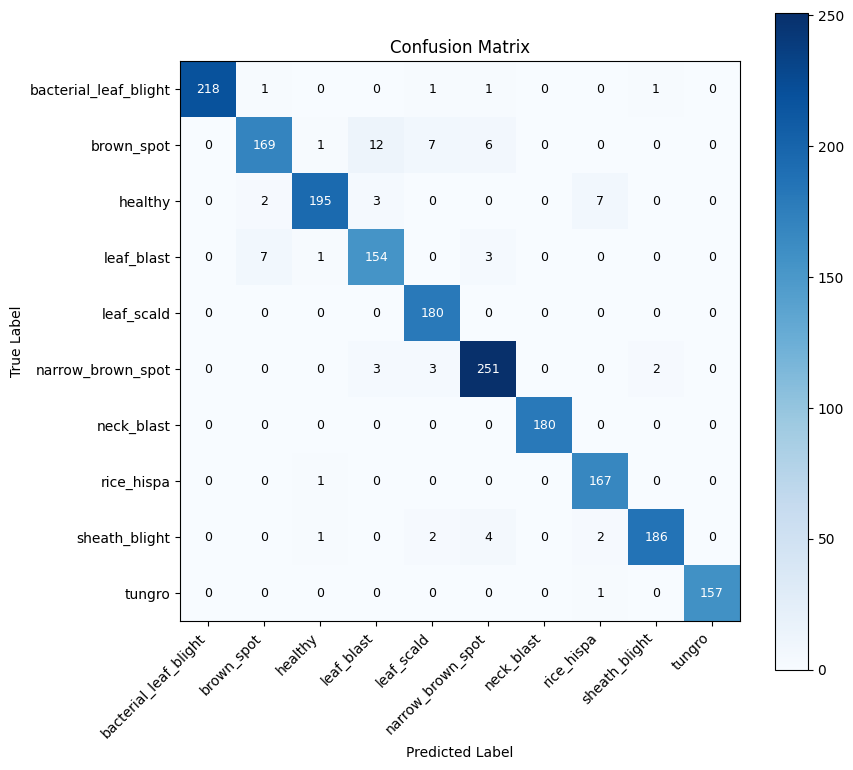

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# True & Predicted labels
y_true = test_gen.classes
y_pred_prob = model.predict(test_gen)
y_pred = np.argmax(y_pred_prob, axis=1)

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(9,8))
plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()

plt.xticks(range(len(class_names)), class_names, rotation=45, ha="right")
plt.yticks(range(len(class_names)), class_names)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")


thresh = cm.max() / 2
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(
            j, i, cm[i, j],
            ha="center", va="center",
            fontsize=9,
            color="white" if cm[i, j] > thresh else "black"
        )

plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
from sklearn.metrics import precision_recall_fscore_support

precision, recall, f1, support = precision_recall_fscore_support(
    y_true, y_pred, average=None
)

classwise_df = pd.DataFrame({
    "Class": class_names,
    "Precision": precision,
    "Recall": recall,
    "F1-Score": f1,
    "Support": support
})

# Round for clean view
classwise_df[["Precision", "Recall", "F1-Score"]] = classwise_df[
    ["Precision", "Recall", "F1-Score"]
].round(4)

classwise_df


NameError: name 'y_true' is not defined

In [ ]:
import pandas as pd
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    mean_squared_error,
    cohen_kappa_score
)

# ---- Calculate metrics ----
metrics = {
    "Accuracy": accuracy_score(y_true, y_pred),
    "Precision (Weighted)": precision_score(y_true, y_pred, average="weighted"),
    "Recall (Weighted)": recall_score(y_true, y_pred, average="weighted"),
    "F1-Score (Weighted)": f1_score(y_true, y_pred, average="weighted"),
    "Mean Squared Error (MSE)": mean_squared_error(y_true, y_pred),
    "Cohen's Kappa": cohen_kappa_score(y_true, y_pred),
}

# ---- Create table ----
metrics_df = pd.DataFrame({
    "Metric": list(metrics.keys()),
    "Value": [round(v, 4) for v in metrics.values()]
})

# ---- Display ----
metrics_df


,Metric,Value
0,Accuracy,0.9627
1,Precision (Weighted),0.9633
2,Recall (Weighted),0.9627
3,F1-Score (Weighted),0.9625
4,Mean Squared Error (MSE),0.3644
5,Cohen's Kappa,0.9584


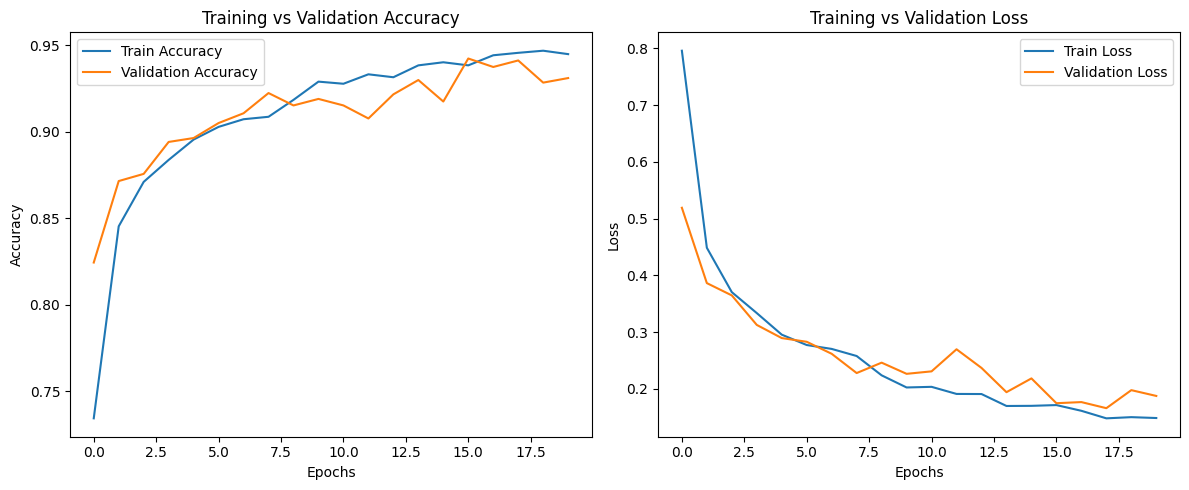

In [ ]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
model.save("/content/drive/MyDrive/rice_disease_densenet121.h5")